Для выполнения этого задания вам понадобятся данные о среднемесячных уровнях заработной платы в России:

#### WAG_C_M.csv

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

#### Review criteria

Придерживайтесь стандартного алгоритма построения прогноза:

* Визуальный анализ ряда
* Стабилизация дисперсии (при необходимости)
* Выбор порядка дифференцирования
* Выбор начальных приближений для $p, q, P, Q$
* Обучение и сравнение моделей-кандидатов, выбор победителя
* Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения $p, q, P, Q$.
* Прогнозирование с помощью финальной модели.

Сдать необходимо ipython-ноутбук с проведённым анализом; пожалуйста, комментируйте в ноутбуке каждый важный шаг построения модели.

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from scipy import stats
from itertools import product
import warnings
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/andrey/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['array', 'product']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
data = pd.read_csv('WAG_C_M.csv', sep = ';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


Посмотрим на данные

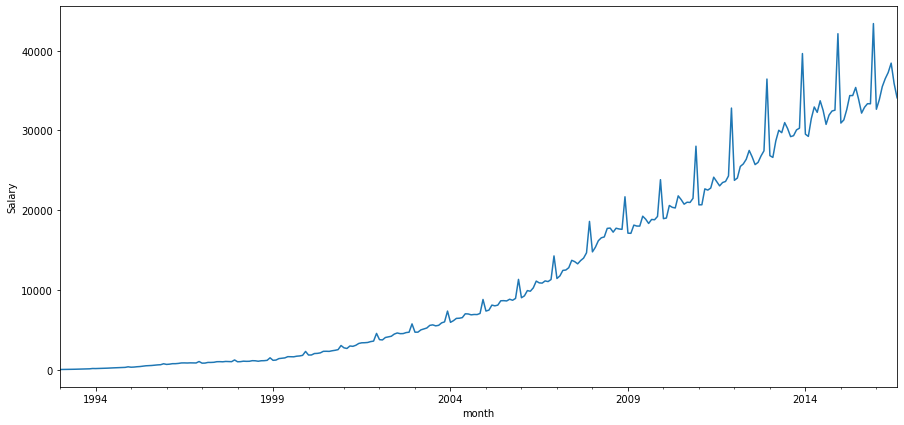

In [3]:
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
plt.ylabel('Salary')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

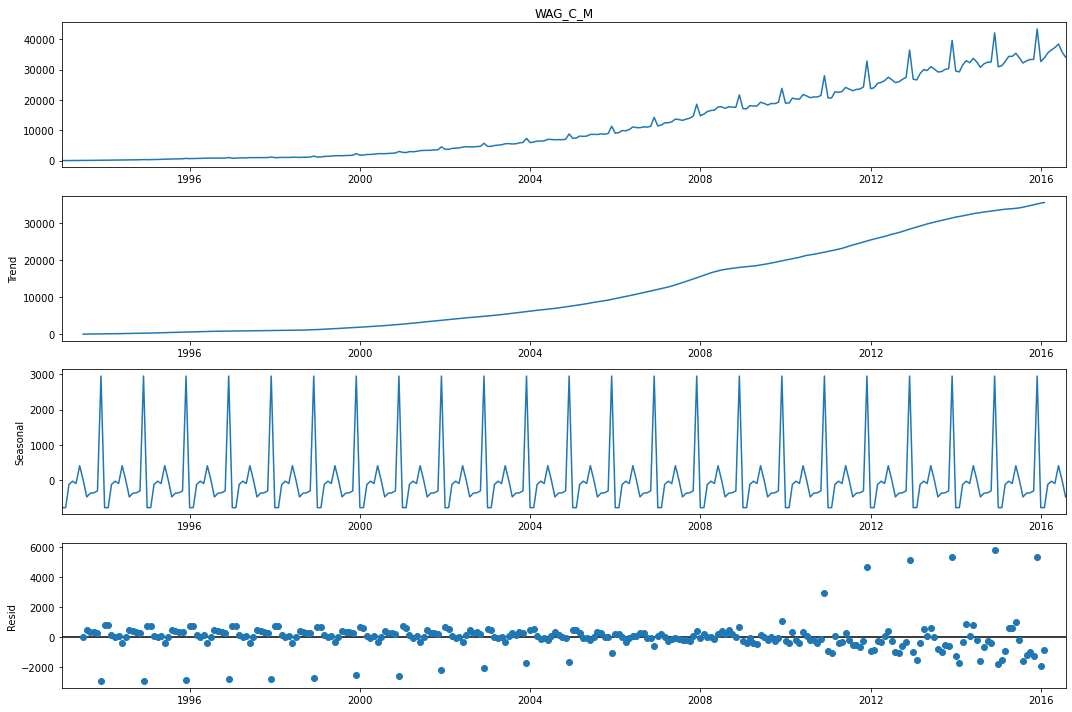

In [4]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

На графике явно прослеживается сезонность и повышающийся тренд. Это видно на первом графике и подтверждается при проверке на стационарность.

Попробуем стабилизировать дисперсию с помощью преобразования Бокса-Кокса:

In [5]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


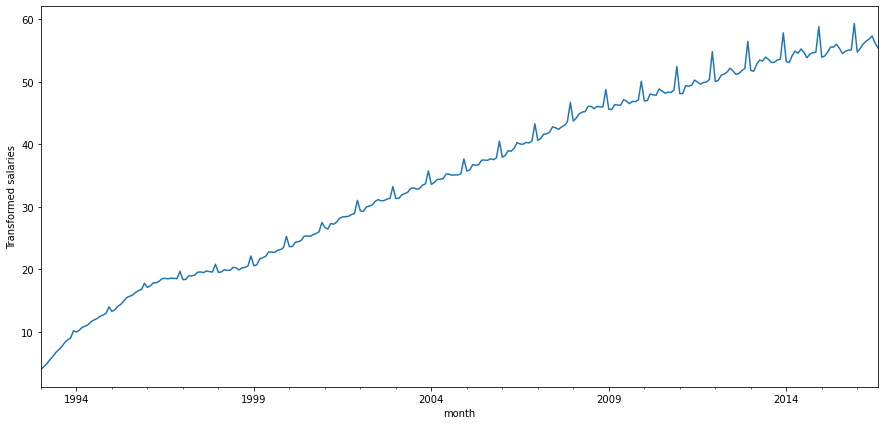

In [6]:
data['wag_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.wag_box.plot()
plt.ylabel(u'Transformed salaries')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wag_box)[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, мы так же хорошо видем. что в данных есть тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

In [7]:
data['wag_diff1'] = data.wag_box - data.wag_box.shift(12)

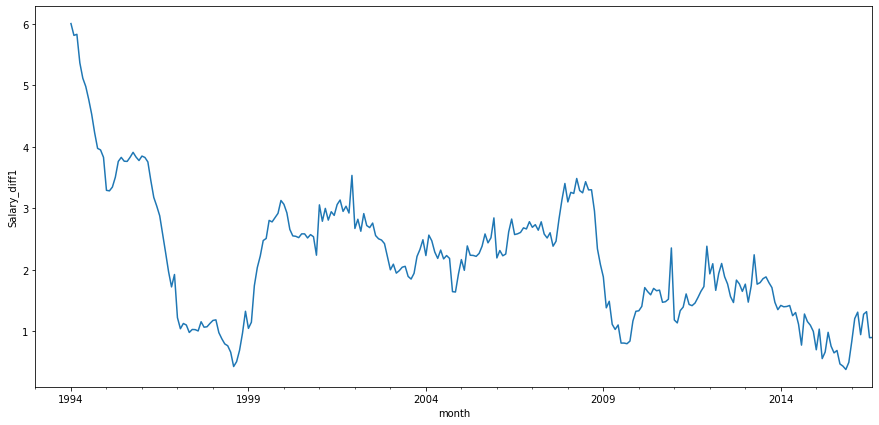

In [8]:
plt.figure(figsize(15,7))
data.wag_diff1.plot()
plt.ylabel('Salary_diff1')
pylab.show()

Проверим критерием Дики-Фуллера ряд на стационарность после первого дифференцирования и посмотрим на него глазами

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

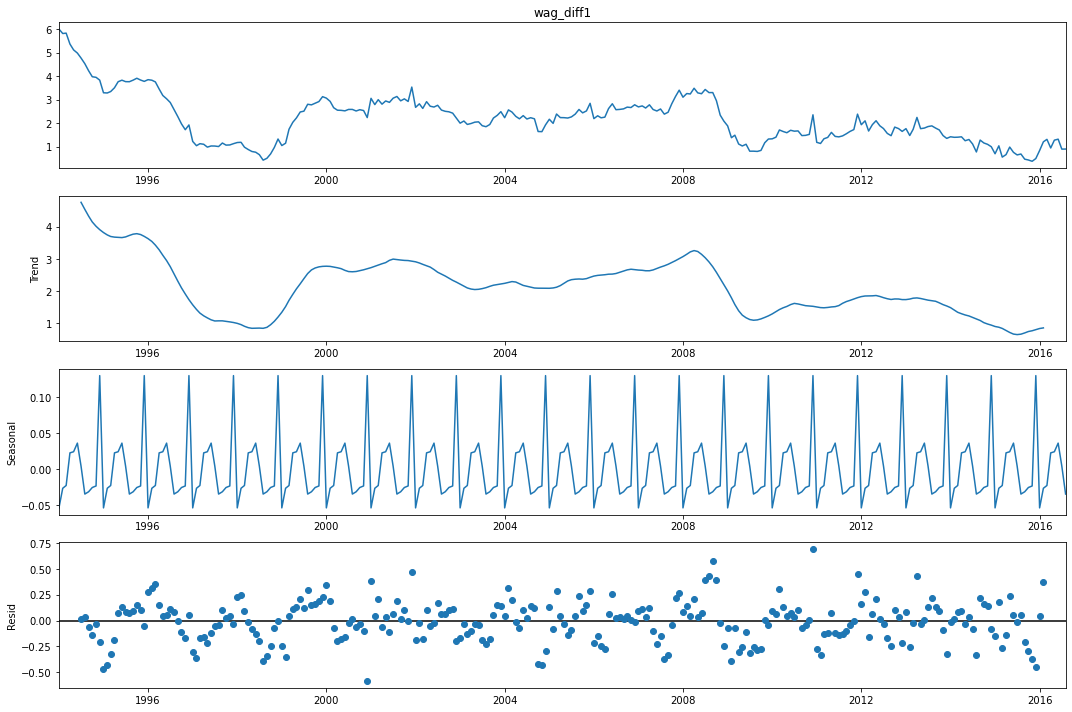

In [9]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wag_diff1.dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wag_diff1.dropna())[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


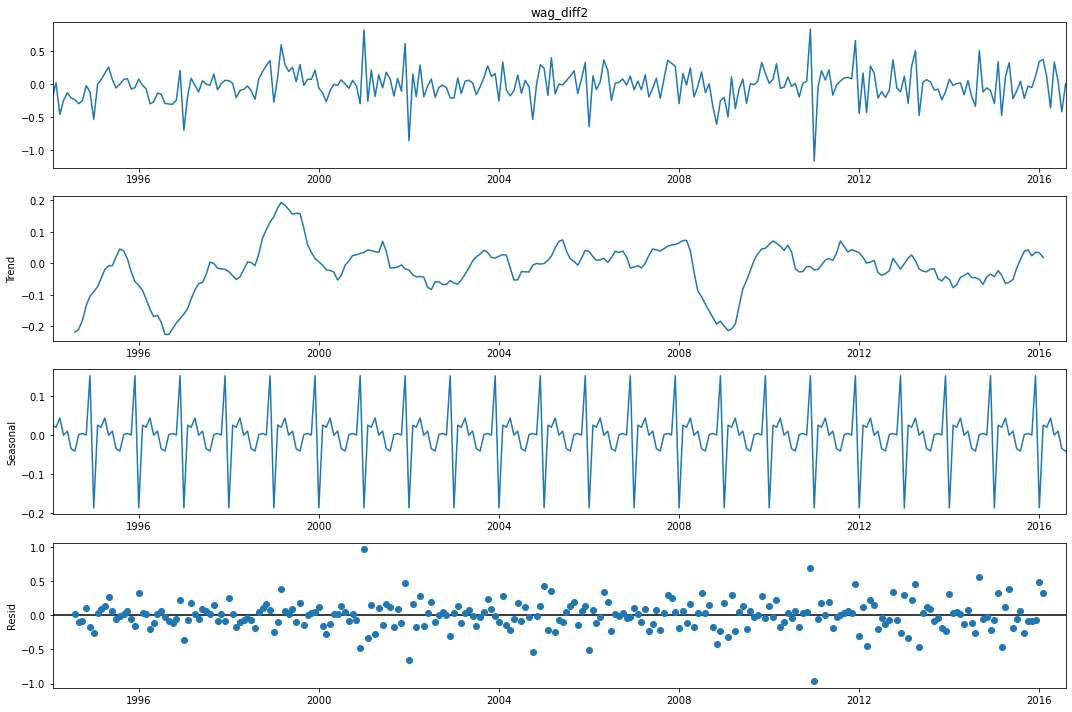

In [10]:
data['wag_diff2'] = data.wag_diff1 - data.wag_diff1.shift(1)
sm.tsa.seasonal_decompose(data.wag_diff2.dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wag_diff2.dropna())[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет.

Видим, что ряд стал стационарным.

Построим графики автокорреляции и частичной автокорреляции для определения начальных параметров $p, q, P, Q$

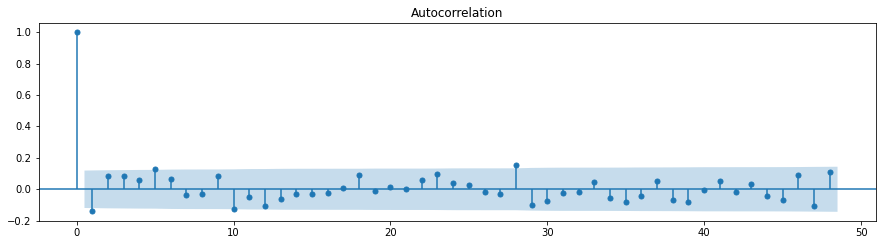

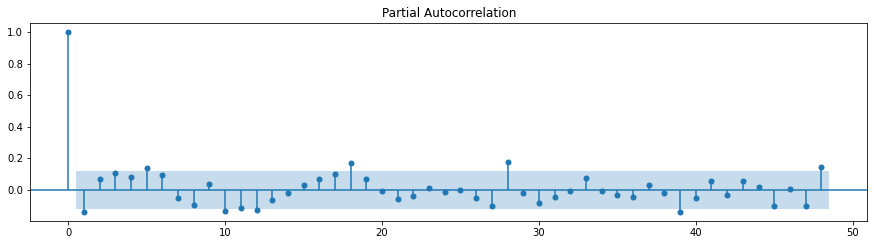

In [11]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.wag_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.wag_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Выберем начальные приближения: Q=0, q=5, P=4, p=5 исходя из графиков

In [48]:
ps = range(0, 6)
Ps = range(0, 5)
qs = range(0, 6)
Qs = range(0, 2)
d=1
D=1

функцию перебора комбинаций написал сам, потому что product отказался работать, все время выдавал ошибку

In [55]:
def my_product(ps, qs, Ps, Qs):
    param = []
    for p in ps:
        for q in qs:
            for P in Ps:
                for Q in Qs:
                    param.append((p, q, P, Q))
    return param

In [57]:
parameters_list = my_product(ps, qs, Ps, Qs)
#parameters_list = list(parameters)
len(parameters_list)

360

In [59]:
# почему-то этот вариант использования встроенной функции постоянно выдавал ошибку, 
#поэтому написал свою функцию с вложенными циклами
#parameters = product(ps, qs, Ps, Qs)
#parameters_list = list(parameters)
#len(parameters_list)

Обучаем нашу модель на вариантах параметров:

In [62]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.wag_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 3h 29min 39s, sys: 1min 19s, total: 3h 30min 58s
Wall time: 1h 48min 55s


P.S. ноутбук старенький, параметров для перебора много, поэтому так долго)))

Посмотрим параметры лучших моделей (лучшая с наименьшим значением критерия)

In [63]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

/home/andrey/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


       parameters        aic
299  (4, 5, 4, 1) -28.986055
149  (2, 2, 4, 1) -27.723521
159  (2, 3, 4, 1) -26.760283
292  (4, 5, 1, 0) -24.912612
352  (5, 5, 1, 0) -24.855420


Лучшая модель:

In [64]:
print(best_model.summary())

/home/andrey/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                      SARIMAX Results                                       
Dep. Variable:                              wag_box   No. Observations:                  284
Model:             SARIMAX(4, 1, 5)x(4, 1, [1], 12)   Log Likelihood                  29.493
Date:                              Fri, 25 Dec 2020   AIC                            -28.986
Time:                                      06:13:26   BIC                             25.046
Sample:                                  01-01-1993   HQIC                            -7.292
                                       - 08-01-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8843      0.102      8.670      0.000       0.684       1.084
ar.L2         -0.38

Остатки полученной модели

/home/andrey/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Критерий Стьюдента: p=0.572365
Критерий Дики-Фуллера: p=0.000000


/home/andrey/anaconda3/lib/python3.8/site-packages/PIL/Image.py:467: DeprecationWarning: PY_SSIZE_T_CLEAN will be required for '#' formats
  return encoder(mode, *args + extra)


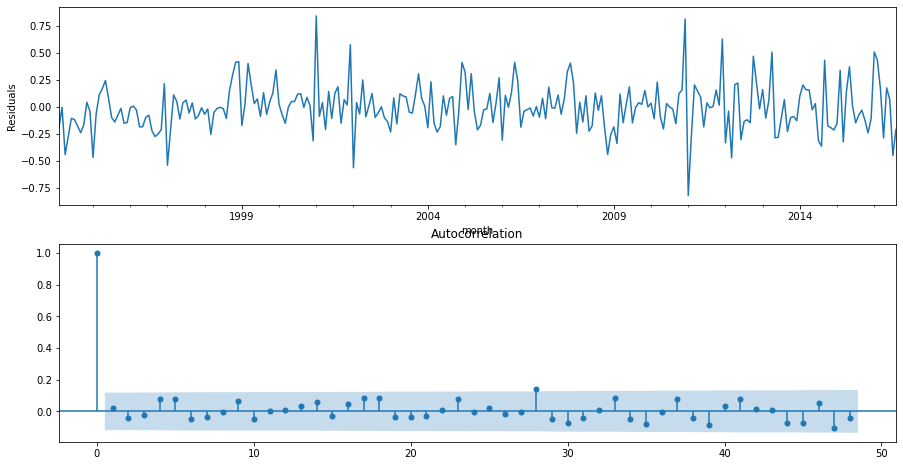

In [65]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента, хотя значение пограничное), стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

/home/andrey/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/andrey/anaconda3/lib/python3.8/site-packages/PIL/Image.py:467: DeprecationWarning: PY_SSIZE_T_CLEAN will be required for '#' formats
  return encoder(mode, *args + extra)


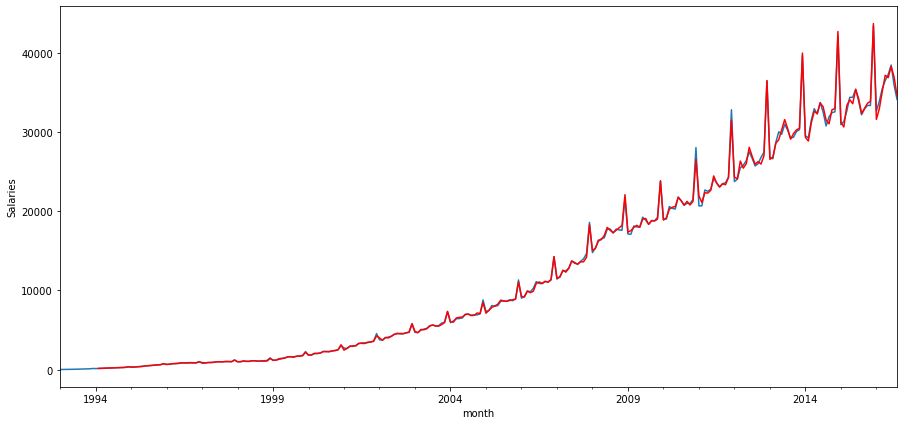

In [67]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('Salaries')
pylab.show()

## Теперь сделаем прогноз

/home/andrey/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/andrey/anaconda3/lib/python3.8/site-packages/PIL/Image.py:467: DeprecationWarning: PY_SSIZE_T_CLEAN will be required for '#' formats
  return encoder(mode, *args + extra)


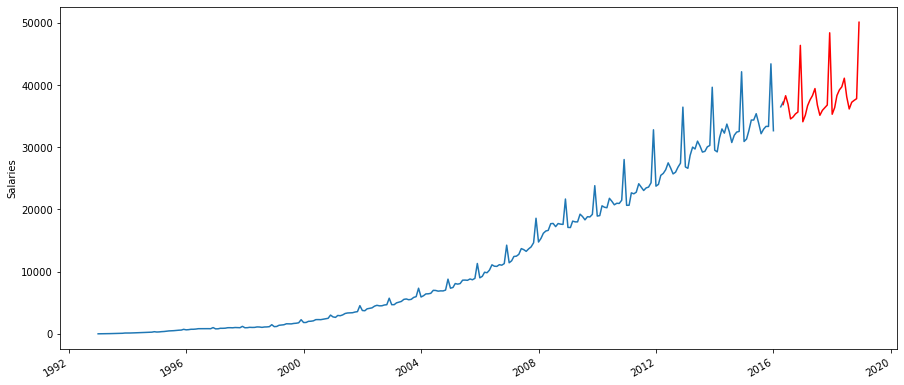

In [72]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=280, end=340), lmbda)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('Salaries')
pylab.show()

К 2020 году прогнозируется средняя зарплата на уровне под 50 тыс. рублей.
В принципе соответствует сегодняшним показателям, предоставляемым Росстатом.